In [18]:
# !pip3 install --upgrade opencv-python-headless==3.4.17.63

# Experiments on the coco dataset for region segmentation

In [17]:

import numpy as np
import pycocotools
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.patches import Polygon
import json
import cv2
import os
import sys
import tqdm
import shapely
from shapely.geometry import Polygon


In [18]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [19]:

from torchvision import io


In [20]:

import albumentations as A


In [21]:

import albumentations.pytorch.transforms as T


In [22]:

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor


In [23]:

# add src to path
sys.path.append('src')
from UNeXt.archs import UNext
from UNeXt.losses import BCEDiceLoss
from pycocotools.coco import COCO
from unet import UNet

%load_ext autoreload
%autoreload 2
from models import *
from datasets import *
from IcyXml import *
from sklearn.metrics import precision_recall_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
model = UNext(5, 3, False)
model.soft = nn.Sigmoid()
# model = UNet(3, 5, False)

# checkpointName = "version_16/checkpoints/epoch=13-val_loss=0.68.ckpt"
# checkpointName = "version_10/checkpoints/epoch=392-val_loss=1.13.ckpt"
# checkpointName = "version_17/checkpoints/epoch=13-val_loss=0.67.ckpt"
# checkpointName = "version_18/checkpoints/epoch=56-val_loss=0.77.ckpt"
# checkpointName = "version_21/checkpoints/epoch=292-val_loss=0.35.ckpt"
# checkpointName = "version_19/checkpoints/epoch=21-val_loss=0.85.ckpt"
# checkpointName = "version_19/checkpoints/epoch=29-val_loss=0.51.ckpt"
# checkpointName = "version_20/checkpoints/epoch=91-val_loss=1.92.ckpt"
# checkpointName = "version_1/checkpoints/epoch=396-val_loss=1.29.ckpt"
# checkpointName = "version_25/checkpoints/epoch=380-val_loss=0.85.ckpt"
# checkpointName = "version_10/checkpoints/epoch=392-val_loss=1.13.ckpt"
# checkpointName = "lightning_logs/version_1/checkpoints/NewDataset-epoch=25-val_loss=1.50.ckpt"
# checkpointName = "lightning_logs/version_7/checkpoints/NewDataset-epoch=00-val_loss=1.73.ckpt"

# checkpointName = "lightning_logs/version_8/checkpoints/NewDataset-epoch=05-val_loss=1.63.ckpt"


checkpointName = "lightning_logs/unext_HL_2/checkpoints/epoch=95-val_loss=0.99.ckpt"
# checkpointName = "lightning_logs/unext/checkpoints/epoch=96-val_loss=1.63.ckpt"

# checkpointName = "M:/FinalWork/RegionSegmentation/src/lightning_logs/version_10/checkpoints/epoch=37-val_loss=1.66.ckpt"
plModel = SegModel(model, None)
plModel = plModel.load_from_checkpoint(checkpointName, backbone=model)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [48]:
# root_dir = "C:/Datasets"
root_dir = "/data"

img_size = 2048

test_transform = A.Compose([
    A.PadIfNeeded(img_size, img_size),
    A.Crop(0, 0, img_size, img_size),
    T.ToTensorV2(transpose_mask=True),
])
ann_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.json')]
ann_files

['/data/Cells.json',
 '/data/CellsInference.json',
 '/data/CellsInferencePure.json',
 '/data/Cells_short.json',
 '/data/forAnalysis.json',
 '/data/Lung_res1.json',
 '/data/NSCLC_RES1.json',
 '/data/NSCLC_RES1_PURE.json',
 '/data/NSCLC_RES1_test.json',
 '/data/TestData.json',
 '/data/ToTest.json']

In [49]:

dataset_test = LungTumorDataset(root_dir, ann_files[2], test_transform)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [50]:
plModel.eval()
# device = plModel.device
annot_file = ann_files[2]


device = "cpu"
model = plModel.to(device)


In [51]:
from torch import threshold
from torchvision.utils import make_grid
from scipy.optimize import linear_sum_assignment

nameFromColor = {"-256": "CD3", "-65536": "Nkp46", "-16711706": "Tryptase"}
colorFromName = {"CD3": "-256", "Nkp46": "-65536", "Tryptase": "-16711706"}

def findIsolatedLocalMaxima(greyScaleImage, threshold=1, squareDiameterLog3=4):
    # squareDiameterLog3 = 4  # 27x27

    total = greyScaleImage
    for axis in range(2):
        d = 1
        for i in range(squareDiameterLog3):
            total = np.maximum(total, np.roll(total, d, axis))
            total = np.maximum(total, np.roll(total, -d, axis))
            d *= 2

    maxima = total == greyScaleImage
    h, w = greyScaleImage.shape

    result = []
    for j in range(h):
        for i in range(w):
            if maxima[j][i] and greyScaleImage[j, i] > threshold:
                result.append((i, j))
    return result

kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (43, 43))

kernel2 = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE, (7, 7))

       

        ###################################### ICYYY STUFF ##################################################
with torch.no_grad():

    for i in tqdm.tqdm(range(len(dataset_test))):
        # torch.cuda.empty_cache()
        img, gtMask = dataset_test[i]
        img_id = dataset_test.ids[i]

        out = model(img.unsqueeze(0).to(device))
        out = torch.sigmoid(out.squeeze(0)).cpu().numpy()

        out = out.astype(np.float32)
        densityMaps = out[-3:]
        # out = torch.sigmoid(out[:-3])
        # print(img_id)
        # img_path = os.path.join(dataset.root_dir, dataset.coco.imgs[img_id]['file_name'])
        img_path = dataset_test.coco.imgs[img_id]['file_name']
        annot_file = ".".join(img_path.split('.')[:-1]) + ".xml"
        # print(img_path, annot_file)

        thresholds = [0.3, 0.3, 0.5, 0.5, 0.5]
        thresholdedMasks = np.zeros_like(out)
        for j in range(len(thresholds)):
            thresholdedMasks[j] = out[j] > thresholds[j]

        icyFile = IcyXml(root_dir, annot_file, img_path, checkpointName)

        contours = extract_contours(dataset_test, (thresholdedMasks[:-3]*255).astype(np.uint8))
        if(contours == []):
            print("No contours found")
        for j, (contour, name, color) in enumerate(contours):
            # print(name)

            icyFile.addPolygon(contour, name, color)

        # print("Tryptase cells detection ... ")
        densityMap = densityMaps[dataset_test.cat2id["Tryptase"]-len(dataset_test.cat2id)+3]
        # print(densityMap.min(), densityMap.max())
        points = np.array(findIsolatedLocalMaxima(densityMap, threshold=0.85, squareDiameterLog3=4))

        for j, point in enumerate(points):
            icyFile.addRoiPoint(point[0], point[1], "Tryptase", dataset_test.name2color["Tryptase"])


        # print("Nkp46 cells detection ... ")
        densityMap = densityMaps[dataset_test.cat2id["Nkp46"]-len(dataset_test.cat2id)+3]
        # print(densityMap.min(), densityMap.max())
        points = np.array(findIsolatedLocalMaxima(densityMap, threshold=0.81, squareDiameterLog3=4))

        for j, point in enumerate(points):
            icyFile.addRoiPoint(point[0], point[1], "Nkp46", dataset_test.name2color["Nkp46"])


        
        # print("CD3 cells detection ... ")
        densityMap = densityMaps[dataset_test.cat2id["CD3"]-len(dataset_test.cat2id)+3]
        # print(densityMap.min(), densityMap.max())
        points = np.array(findIsolatedLocalMaxima(densityMap, threshold=0.7, squareDiameterLog3=3))

        for j, point in enumerate(points):
            icyFile.addRoiPoint(point[0], point[1], "CD3",  dataset_test.name2color["CD3"])


            
        icyFile.save(out)


    #    thresholds = [0.32, 0.5, 0.3, 0.003, 0.02, 0.02, 0.03, 0.02, 0.02, 0.68, 0.98, 0.98]
    #     thresholdedMasks = np.zeros_like(out)
    #     for j in range(len(thresholds)):
    #         thresholdedMasks[j] = out[j] > thresholds[j]

100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [01:37<00:00,  3.90s/it]


In [33]:
dataset_test.id2cat

{0: 'Tumor Islet', 1: 'Necrotic', 2: 'Nkp46', 3: 'Tryptase', 4: 'CD3'}

In [12]:
# with torch.no_grad():

#     for i in tqdm.tqdm(range(len(dataset_test))):
#         # torch.cuda.empty_cache()
#         img, gtMask = dataset_test[i]
#         img_id = dataset_test.ids[i]

#         out = model(img.unsqueeze(0).to(device))
#         out = torch.sigmoid(out).squeeze(0).cpu().numpy()

#         out = out.astype(np.float32)
#         densityMaps = out[-3:]
        
#         prec_rec_curve = plt.figure(figsize=(10, 8))
#         for i in range(2):
#             precision, recall, thresholds = precision_recall_curve(gtMask[i].reshape(-1), out[i].reshape(-1))
#             print(len(thresholds))
#             precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
#             recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
#             AUC_prec_rec = np.trapz(precision,recall)
# #             print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
            
#             plt.plot(recall,precision,'-',label=f"{dataset_test.id2cat[i]} (AUC = {AUC_prec_rec:.2f})")
#         plt.title('Precision - Recall curve for region segmentation')
#         plt.xlabel("Recall")
#         plt.ylabel("Precision")
#         plt.legend(loc="lower right")
#         plt.grid()
#         plt.show()
        
        
#         prec_rec_curve = plt.figure(figsize=(10, 8))
#         for i in range(2, 5):
#             precision, recall, thresholds = precision_recall_curve(gtMask[i].reshape(-1)>0, out[i].reshape(-1))
#             print(len(thresholds))
#             precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
#             recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
#             AUC_prec_rec = np.trapz(precision,recall)
# #             print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
            
#             plt.plot(recall,precision,'-',label=f"{dataset_test.id2cat[i]} (AUC = {AUC_prec_rec:.2f})")
#         plt.title('Precision - Recall curve for cell detection')
#         plt.xlabel("Recall")
#         plt.ylabel("Precision")
#         plt.legend(loc="lower right")
#         plt.grid()
#         plt.show()
        
# #         plt.figure()
# #         plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
# #         plt.plot(thresholds, recall[:-1], 'r--', label='Recall')
# #         plt.xlabel('Threshold')
# #         plt.legend(loc='lower left')
# #         plt.ylim([0,1])
# #         plt.show()
#         #

100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:31<00:00,  1.26s/it]


Area under Precision-Recall curve tumorIlets: 0.9134381447491959

Area under Precision-Recall curve tumorIlets: 0.14863371326073782


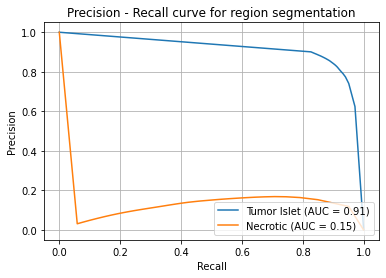

In [16]:
import sklearn

def precision_recall_curve(y_true, pred_scores, thresholds):
    TPs = []
    FPs = []
    FNs = []
    
    for threshold in thresholds:
        y_pred = (pred_scores >= threshold)*1.0#np.array([1 if score >= threshold else 0 for score in pred_scores])
        # print(np.unique(y_pred))
        # precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label=1)
        # recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label=1)
        # print(y_true[:10], y_pred[:10])
        TP = ((y_pred == 1) * (y_true == 1)).sum()
        FN = ((y_pred == 0) * (y_true == 1)).sum()
        FP = ((y_pred == 1) * (y_true == 0)).sum()
        # print(TP, FN, FP)
        TPs.append(TP)
        FPs.append(FP)
        FNs.append(FN)
        
        
    return TPs, FPs, FNs

    # return [0, *precisions, 1], [1, *recalls, 0]

# x = np.linspace(0, 1, 10)
# y = (x-3)**3 - 0.02*x

# thresholds = (y-y.min())/(y.max() - y.min())
thresholds = np.linspace(0.01, 0.9, 40)

TP_tumor = np.zeros_like(thresholds)
TP_necro = np.zeros_like(thresholds)
FP_tumor = np.zeros_like(thresholds)
FP_necro = np.zeros_like(thresholds)
FN_tumor = np.zeros_like(thresholds)
FN_necro = np.zeros_like(thresholds)

with torch.no_grad():

    for i in tqdm.tqdm(range(len(dataset_test))):
        # torch.cuda.empty_cache()
        img, gtMask = dataset_test[i]
        img_id = dataset_test.ids[i]

        out = model(img.unsqueeze(0).to(device))
        out = torch.sigmoid(out).squeeze(0).cpu().numpy()

        out = out.astype(np.float32)
        # densityMaps = out[-3:]

        TP, FP, FN = precision_recall_curve(gtMask[0].cpu().numpy().reshape(-1), out[0].reshape(-1), thresholds)

        TP_tumor += TP
        FP_tumor += FP
        FN_tumor += FN
        
        # precisionTumorIlets += np.fliplr([precision])[0]  #to avoid getting negative AUC)
        # recallTumorIlets += np.fliplr([recall])[0]  #to avoid getting negative AUC)
        
        TP, FP, FN = precision_recall_curve(gtMask[1].cpu().numpy().reshape(-1), out[1].reshape(-1), thresholds)
        # print(out[1].min(), out[1].max(), FN, gtMask.shape)
        TP_necro += TP
        FP_necro += FP
        FN_necro += FN
        # print(TP, FP, FN)
#         precisionNecrotic += np.fliplr([precision])[0]  #to avoid getting negative AUC)
#         recallNecrotic += np.fliplr([recall])[0]  #to avoid getting negative AUC)
        
        
    # print(TP_tumor)
    recallTumorIlets = TP_tumor/(TP_tumor+FN_tumor)
    precisionTumorIlets = TP_tumor/(TP_tumor+FP_tumor)
    precisionTumorIlets = np.fliplr([np.array([0, *precisionTumorIlets, 1])])[0]  #to avoid getting negative AUC)
    recallTumorIlets = np.fliplr([np.array([1, *recallTumorIlets, 0])])[0]  #to avoid getting negative AUC)
    AUC_prec_rec_TumorIlets = np.trapz(precisionTumorIlets,recallTumorIlets)
    print("\nArea under Precision-Recall curve tumorIlets: " +str(AUC_prec_rec_TumorIlets))
    plt.plot(recallTumorIlets,precisionTumorIlets,'-',label=f"{dataset_test.id2cat[0]} (AUC = {AUC_prec_rec_TumorIlets:.2f})")
    
    
    # print(TP_necro, FN_necro)
    recallNecrotic = TP_necro/(TP_necro+FN_necro)
    recallNecrotic = np.where((TP_necro+FN_necro) == 0, 1, recallNecrotic)
    precisionNecrotic  = TP_necro/(TP_necro+FP_necro)
    # precisionNecrotic = np.where((TP_necro+FP_necro).sum() == 0, 1, precisionNecrotic)
    
    precisionNecrotic = np.fliplr([np.array([0, *precisionNecrotic, 1])])[0]  #to avoid getting negative AUC)
    recallNecrotic = np.fliplr([np.array([1, *recallNecrotic, 0])])[0]  #to avoid getting negative AUC)
    AUC_prec_rec_Necrotic = np.trapz(precisionNecrotic,recallNecrotic)
    print("\nArea under Precision-Recall curve tumorIlets: " +str(AUC_prec_rec_Necrotic))
    plt.plot(recallNecrotic,precisionNecrotic,'-',label=f"{dataset_test.id2cat[1]} (AUC = {AUC_prec_rec_Necrotic:.2f})")
    
    
    plt.title('Precision - Recall curve for region segmentation')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
        
        
#         prec_rec_curve = plt.figure(figsize=(10, 8))
#         for i in range(2, 5):
#             precision, recall, thresholds = precision_recall_curve(gtMask[i].reshape(-1)>0, out[i].reshape(-1))
#             print(len(thresholds))
#             precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
#             recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
#             AUC_prec_rec = np.trapz(precision,recall)
# #             print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
            
#             plt.plot(recall,precision,'-',label=f"{dataset_test.id2cat[i]} (AUC = {AUC_prec_rec:.2f})")
#         plt.title('Precision - Recall curve for cell detection')
#         plt.xlabel("Recall")
#         plt.ylabel("Precision")
#         plt.legend(loc="lower right")
#         plt.grid()
#         plt.show()
        
#         plt.figure()
#         plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
#         plt.plot(thresholds, recall[:-1], 'r--', label='Recall')
#         plt.xlabel('Threshold')
#         plt.legend(loc='lower left')
#         plt.ylim([0,1])
#         plt.show()
        #

In [56]:
x = np.linspace(0, 1, 100)

In [57]:
y = (x-3)**3 - 0.02*x

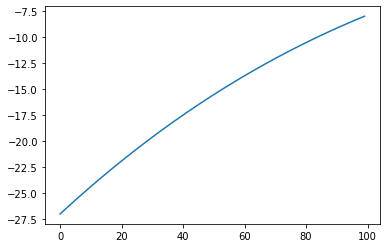

In [59]:
plt.plot(y)